# Proyecto NLP Semillero DSRP: TOPIC MODELLING

Datasets disponibles en: https://www.kaggle.com/datasets/lazaro97/peruvian-food-reviews

## Librerías y Funciones

In [ ]:
!pip install pyLDAvis

In [ ]:
import re
import numpy as np
import pandas as pd
from unicodedata import normalize
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from spacy.lang.es.stop_words import STOP_WORDS

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import random

In [ ]:
random.seed(42) 

spanish_stopwords = stopwords.words('spanish')
all_stopwords=list(set(spanish_stopwords+list(STOP_WORDS)+['q','pq','xd','xq']))

wlm = WordNetLemmatizer()

In [ ]:
def preprocesamiento_reviews(text):
  text = text.lower()

  text = re.sub('[áàä]', 'a', text)
  text = re.sub('[éèë]', 'e', text)
  text = re.sub('[íìï]', 'i', text)
  text = re.sub('[óòö]', 'o', text)
  text = re.sub('[úùü]', 'u', text)

  text = re.sub('[.,:;]', '', text)
  text = re.sub(r'[`´“”¿?!¡\)\(%\\\/‘’\[\]|]', '', text)
  text = re.sub(r'\d{1,}', '', text)
  text = re.sub(r'[-–—]', ' ', text)
  text = re.sub('``', '', text)
  text = re.sub(r' {2,}', ' ',text)

  return text

def procesamiento_reviews(texto_original, stopwords=all_stopwords):
  tokens = word_tokenize(texto_original)
  texto_limpio = ' '.join([t for t in tokens if t not in stopwords])

  return texto_limpio

def text_preprocesor(sentence: str):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    tokens = [wlm.lemmatize(word) for word in nltk.word_tokenize(sentence.lower()) if (word not in all_stopwords) and re.search('[a-zA-Z]', word)]

    return tokens

def get_lda_model(NUM_TOPICS, texts, dictionary):
  lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                              id2word=dictionary, 
                                              passes=15)
  
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  
  return coherence_lda



## Lectura de Dataframes y pre-procesamiento inicial

In [ ]:
reviews_df=pd.read_csv('/content/drive/MyDrive/proyecto NLP/NLP/proyecto/reviews.csv')
reviews_df.dropna(subset=['review'],inplace=True)
reviews_df.drop_duplicates(subset=['review'],inplace=True,keep=False)
restaurants_df=pd.read_csv('/content/drive/MyDrive/proyecto NLP/NLP/proyecto/restaurants.csv')

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552299 entries, 0 to 1258434
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id_review  552299 non-null  object 
 1   review     552299 non-null  object 
 2   title      552299 non-null  object 
 3   score      552299 non-null  float64
 4   likes      552299 non-null  int64  
 5   id_nick    552299 non-null  object 
 6   service    552299 non-null  float64
 7   date       552299 non-null  object 
 8   platform   552299 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 42.1+ MB


In [ ]:
reviews_df['review_prep'] = reviews_df['review'].apply(preprocesamiento_reviews)

In [ ]:
reviews_df['review_final'] = reviews_df['review_prep'].apply(procesamiento_reviews)

In [ ]:
reviews_df.dropna(subset=['review_final'], inplace=True)

In [ ]:
reviews_df.head()

,id_review,review,title,score,likes,id_nick,service,date,platform,review_prep,review_final
0,R1245,Muy buena presentación y servicio sin embargo ...,Muy buena presentación y servicio,3.0,0,uisahelenad2018,71036.0,1 years ago,tripadvisor,muy buena presentacion y servicio sin embargo ...,presentacion servicio exageradamente costoso i...
1,R1246,Desde la presentación de los platos a la calid...,Una experiencia,5.0,0,turrutia,71036.0,1 years ago,tripadvisor,desde la presentacion de los platos a la calid...,presentacion platos calidad alimentos vinos ex...
2,R1247,El mejor lugar para reencontrame con mis amigo...,Felicitaciones a Statera!,5.0,0,orthStar25333985745,71036.0,1 years ago,tripadvisor,el mejor lugar para reencontrame con mis amigo...,lugar reencontrame amigos queridos peru visita...
3,R1248,Excelente experiencia Comida maravillosa con e...,Aniversario de boda,5.0,0,atima J,71036.0,1 years ago,tripadvisor,excelente experiencia comida maravillosa con e...,excelente experiencia comida maravillosa excel...
4,R1249,Mi pasión es viajar y disfrutar de las grandez...,No te lo querrás perder!,5.0,0,nbocadoalmundo,71036.0,1 years ago,tripadvisor,mi pasion es viajar y disfrutar de las grandez...,pasion viajar disfrutar grandezas pais sobreto...


In [ ]:
reviews_df = reviews_df.loc[reviews_df['review_final'] != '']

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550314 entries, 0 to 1258434
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_review     550314 non-null  object 
 1   review        550314 non-null  object 
 2   title         550314 non-null  object 
 3   score         550314 non-null  float64
 4   likes         550314 non-null  int64  
 5   id_nick       550314 non-null  object 
 6   service       550314 non-null  float64
 7   date          550314 non-null  object 
 8   platform      550314 non-null  object 
 9   review_prep   550314 non-null  object 
 10  review_final  550314 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 50.4+ MB


##Visualización y Cantidad de reseñas por SCORE

In [ ]:
df_tmp = reviews_df[['score', 'review']]

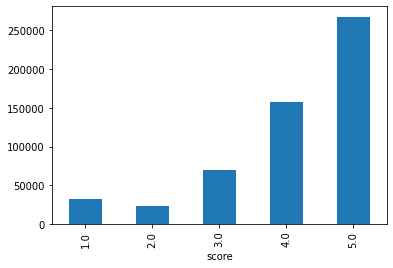

In [ ]:
df_tmp.groupby('score').count().plot(kind='bar', legend=None)

## Selección de reseñas negativas (Score =1) y Procesado Final

In [ ]:
df_reviews_negativos = reviews_df.loc[reviews_df.score == 1]

In [ ]:
df_reviews_negativos.head()

,id_review,review,title,score,likes,id_nick,service,date,platform,review_prep,review_final
215,R3005,Los acompañamientos muy malos. Los cortes de c...,Una mala experiencia,1.0,0,87carlosi,35956.0,1 years ago,tripadvisor,los acompañamientos muy malos los cortes de ca...,acompañamientos malos cortes carne vienen pone...
225,R3015,Trabajan dos versiones diferentes de la misma ...,Facturan de más sin avisar.,1.0,0,ervas10,35956.0,1 years ago,tripadvisor,trabajan dos versiones diferentes de la misma ...,trabajan versiones etiqueta cepa vino caso tra...
247,R3037,Llegue a este restaurante por recomendación de...,Un restaurante de Buda y despedida,1.0,0,osé M,35956.0,2 years ago,tripadvisor,llegue a este restaurante por recomendacion de...,llegue restaurante recomendacion youtuber loca...
268,R3058,Los 330 soles (US$100) peor invertidos. Fui co...,Malísimo !,1.0,0,abiioooo,35956.0,2 years ago,tripadvisor,los soles us$ peor invertidos fui con mi hija ...,soles us $ invertidos hija cabrera miraflores ...
282,R3072,Acudimos en familia con ocasión de celebrar el...,Muy mala experiencia una decepción total,1.0,0,ongala,35956.0,3 years ago,tripadvisor,acudimos en familia con ocasion de celebrar el...,acudimos familia ocasion celebrar cumpleaños h...


In [ ]:
# Frecuencia de palabras
freq = FreqDist(word_tokenize(' '.join(df_reviews_negativos.review_final)))
freq.most_common(20)

[('atencion', 8711),
 ('comida', 6447),
 ('mala', 4250),
 ('pollo', 3431),
 ('servicio', 3318),
 ('lugar', 3292),
 ('pesima', 3290),
 ('pesimo', 2964),
 ('sabor', 2926),
 ('pedido', 2566),
 ('pedi', 2170),
 ('local', 2050),
 ('recomiendo', 1961),
 ('calidad', 1885),
 ('minutos', 1883),
 ('``', 1768),
 ('platos', 1756),
 ('hora', 1678),
 ('plato', 1641),
 ('restaurante', 1568)]

### Palabras más frecuentes en los reviews negativos

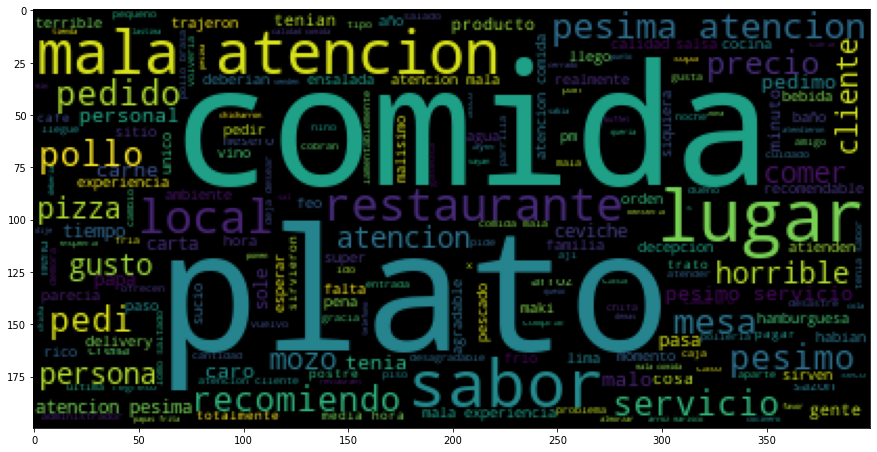

In [ ]:
wordcloud = WordCloud().generate(' '.join(df_reviews_negativos.review_final))

plt.figure(figsize=[15,8])
plt.imshow(wordcloud)

### Tokenización Y lematización:

In [ ]:
doc_list = list(df_reviews_negativos.review_final.apply(text_preprocesor))

In [ ]:
doc_list[:2]

In [ ]:
df_reviews_negativos['review_final_token']=doc_list

In [ ]:
df_reviews_negativos.head()

,id_review,review,title,score,likes,id_nick,service,date,platform,review_prep,review_final,review_final_token
215,R3005,Los acompañamientos muy malos. Los cortes de c...,Una mala experiencia,1.0,0,87carlosi,35956.0,1 years ago,tripadvisor,los acompañamientos muy malos los cortes de ca...,acompañamientos malos cortes carne vienen pone...,"[acompañamientos, malos, cortes, carne, vienen..."
225,R3015,Trabajan dos versiones diferentes de la misma ...,Facturan de más sin avisar.,1.0,0,ervas10,35956.0,1 years ago,tripadvisor,trabajan dos versiones diferentes de la misma ...,trabajan versiones etiqueta cepa vino caso tra...,"[trabajan, versiones, etiqueta, cepa, vino, ca..."
247,R3037,Llegue a este restaurante por recomendación de...,Un restaurante de Buda y despedida,1.0,0,osé M,35956.0,2 years ago,tripadvisor,llegue a este restaurante por recomendacion de...,llegue restaurante recomendacion youtuber loca...,"[llegue, restaurante, recomendacion, youtuber,..."
268,R3058,Los 330 soles (US$100) peor invertidos. Fui co...,Malísimo !,1.0,0,abiioooo,35956.0,2 years ago,tripadvisor,los soles us$ peor invertidos fui con mi hija ...,soles us $ invertidos hija cabrera miraflores ...,"[sol, u, invertidos, hija, cabrera, miraflores..."
282,R3072,Acudimos en familia con ocasión de celebrar el...,Muy mala experiencia una decepción total,1.0,0,ongala,35956.0,3 years ago,tripadvisor,acudimos en familia con ocasion de celebrar el...,acudimos familia ocasion celebrar cumpleaños h...,"[acudimos, familia, ocasion, celebrar, cumplea..."


In [ ]:
df_reviews_negativos.shape

(32001, 12)

In [ ]:
#df_reviews_negativos.to_csv('/content/drive/MyDrive/proyecto NLP/NLP/proyecto_v2/df_reviews_negativos.csv')


## Construyendo y evaluando los modelos

In [ ]:
dictionary = corpora.Dictionary(df_reviews_negativos['review_final_token'])
corpus = [dictionary.doc2bow(text) for text in df_reviews_negativos['review_final_token']]

In [ ]:
len(corpus)

32001

In [ ]:
# Frecuencia de palabras únicas en el corpus
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('acompañamientos', 2),
  ('calidad', 1),
  ('carne', 1),
  ('causa', 1),
  ('cayo', 1),
  ('cliente', 1),
  ('comida', 2),
  ('cortes', 1),
  ('dando', 1),
  ('decia', 1),
  ('desconociendo', 1),
  ('diversos', 1),
  ('entender', 1),
  ('mala', 1),
  ('malos', 1),
  ('ponen', 1),
  ('post', 1),
  ('problema', 1),
  ('productos', 1),
  ('queja', 1),
  ('recomendable', 1),
  ('referentes', 1),
  ('reporte', 1),
  ('respuestas', 1),
  ('restaurante', 1),
  ('servicio', 1),
  ('trato', 1),
  ('venta', 1),
  ('vienen', 1)],
 [('cliente', 1),
  ('comida', 1),
  ('restaurante', 1),
  ('trato', 1),
  ('abrir', 1),
  ('argentina', 1),
  ('botella', 2),
  ('cara', 1),
  ('caso', 1),
  ('cepa', 1),
  ('cobrado', 1),
  ('coloca', 1),
  ('consultar', 1),
  ('cuesta', 1),
  ('desea', 1),
  ('dimos', 1),
  ('doble', 1),
  ('entrenado', 1),
  ('espera', 1),
  ('estafa', 1),
  ('etiqueta', 1),
  ('facturado', 1),
  ('guarniciones', 3),
  ('habian', 2),
  ('logicamente', 1),
  ('lugar', 1),
  ('malbe

In [ ]:
# Construir LDA model inicial con 5 tópicos
NUM_TOPICS = 5

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

In [ ]:
from pprint import pprint
# Print the Keyword in the 5 topics
pprint(ldamodel.print_topics())
doc_lda = ldamodel[corpus]

[(0,
  '0.009*"baño" + 0.007*"niños" + 0.007*"lugar" + 0.007*"cuidado" + '
  '0.006*"hamburguesas" + 0.006*"seguridad" + 0.006*"sucio" + 0.006*"local" + '
  '0.006*"gusta" + 0.005*"productos"'),
 (1,
  '0.032*"pollo" + 0.025*"sabor" + 0.017*"comida" + 0.015*"papa" + '
  '0.013*"plato" + 0.012*"pedi" + 0.011*"gusto" + 0.010*"calidad" + '
  '0.010*"caro" + 0.009*"arroz"'),
 (2,
  '0.095*"atencion" + 0.044*"mala" + 0.040*"comida" + 0.036*"pesima" + '
  '0.016*"servicio" + 0.013*"personal" + 0.012*"lugar" + 0.012*"demoran" + '
  '0.011*"recomiendo" + 0.010*"plato"'),
 (3,
  '0.121*"pesimo" + 0.093*"trato" + 0.089*"estacionamiento" + 0.088*"cumplen" '
  '+ 0.087*"horarios" + 0.087*"alabrir" + 0.016*"servicio" + 0.012*"pedido" + '
  '0.012*"delivery" + 0.007*"esperando"'),
 (4,
  '0.012*"mesa" + 0.010*"persona" + 0.009*"minutos" + 0.009*"restaurante" + '
  '0.008*"lugar" + 0.007*"comer" + 0.006*"pedido" + 0.006*"pedi" + '
  '0.006*"local" + 0.006*"mozo"')]


In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=df_reviews_negativos['review_final_token'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47338158897851734


### Hallando número óptimo de tópicos Gensim LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
      model= gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, random_state=100, passes=15)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df_reviews_negativos['review_final_token'], start=2, limit=8, step=1)

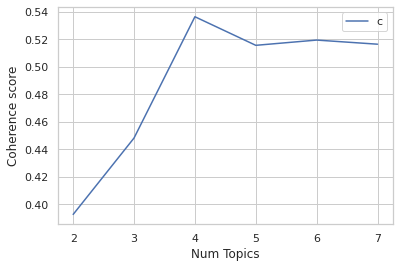

In [ ]:
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, "valor de coherencia", round(cv, 4))

Num Topics = 2 valor de coherencia 0.3928
Num Topics = 3 valor de coherencia 0.4483
Num Topics = 4 valor de coherencia 0.5363
Num Topics = 5 valor de coherencia 0.5155
Num Topics = 6 valor de coherencia 0.5193
Num Topics = 7 valor de coherencia 0.5163


Parece que 4 tópicos nos dan el mayor valor de coherencia.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.095*"atencion" + 0.039*"mala" + 0.036*"pesima" + 0.034*"comida" + '
  '0.017*"lugar" + 0.013*"servicio" + 0.012*"demoran" + 0.012*"personal" + '
  '0.011*"local" + 0.009*"falta"'),
 (1,
  '0.027*"pollo" + 0.021*"sabor" + 0.019*"comida" + 0.015*"plato" + '
  '0.013*"papa" + 0.011*"pedi" + 0.010*"calidad" + 0.009*"precio" + '
  '0.009*"gusto" + 0.008*"caro"'),
 (2,
  '0.020*"pedido" + 0.014*"minutos" + 0.013*"hora" + 0.012*"servicio" + '
  '0.010*"mesa" + 0.008*"delivery" + 0.007*"persona" + 0.006*"demoraron" + '
  '0.006*"tiempo" + 0.006*"plato"'),
 (3,
  '0.152*"pesimo" + 0.116*"trato" + 0.112*"estacionamiento" + 0.111*"cumplen" '
  '+ 0.110*"horarios" + 0.110*"alabrir" + 0.002*"bembos" + 0.002*"k" + '
  '0.001*"malazo" + 0.001*"maria"')]


In [ ]:
NUM_TOPICS = 4

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, random_state=100,
                                           passes=15)

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=df_reviews_negativos['review_final_token'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5362770795456788


In [ ]:
# Visualizar tópicos
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### Utilizando LDA mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import os.path
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path='/content/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=dictionary, workers=8)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=doc_list, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('mesa', 0.020946326859897748),
   ('restaurante', 0.015240761260473164),
   ('persona', 0.012869112186777084),
   ('comer', 0.008854804533348885),
   ('mozo', 0.008252172391672013),
   ('plato', 0.007727299236017962),
   ('pedir', 0.007387103672168115),
   ('carta', 0.00729962481289244),
   ('lugar', 0.007212145953616765),
   ('pedimos', 0.006220718881825781)]),
 (1,
  [('atencion', 0.10082642714940507),
   ('comida', 0.0746215102551044),
   ('mala', 0.049168943006620676),
   ('pesima', 0.038080466688272606),
   ('lugar', 0.02951525533589518),
   ('recomiendo', 0.022697810083800177),
   ('calidad', 0.021818139728691142),
   ('pizza', 0.014236770220843558),
   ('demoran', 0.012153340432427428),
   ('experiencia', 0.012037594333070976)]),
 (2,
  [('servicio', 0.036894585311086164),
   ('pesimo', 0.03291499460865505),
   ('pedido', 0.02852410542580509),
   ('local', 0.022788159050233996),
   ('minutos', 0.020331484342867308),
   ('hora', 0.01865294189575251),
   ('personal', 0.01

Se incrementó en 6% la coherencia.

In [ ]:
def compute_coherence_values_2(dictionary, corpus, texts, limit, start=2, step=1):

  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
      model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=8)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values_2(dictionary=dictionary, corpus=corpus, texts=df_reviews_negativos['review_final_token'], start=2, limit=8, step=1)

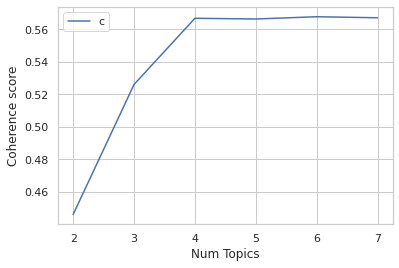

In [ ]:
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, "valor de coherencia", round(cv, 4))

Num Topics = 2 valor de coherencia 0.4461
Num Topics = 3 valor de coherencia 0.5261
Num Topics = 4 valor de coherencia 0.5669
Num Topics = 5 valor de coherencia 0.5665
Num Topics = 6 valor de coherencia 0.5679
Num Topics = 7 valor de coherencia 0.5672


Se observa un ligero incremento en el valor de la coherencia con 6 tópicos, pero no es lo suficiente como para elegirlos.

In [ ]:
# Select the model and print the topics
optimal_model_mallet = model_list[2]
model_topics = optimal_model_mallet.show_topics(formatted=False)
pprint(optimal_model_mallet.print_topics(num_words=20))

[(0,
  '0.025*"pedido" + 0.021*"mesa" + 0.019*"minutos" + 0.014*"hora" + '
  '0.013*"persona" + 0.008*"mozo" + 0.008*"tiempo" + 0.007*"pedir" + '
  '0.007*"llego" + 0.007*"esperar" + 0.006*"restaurante" + 0.006*"esperando" + '
  '0.006*"espera" + 0.006*"momento" + 0.006*"pedimos" + 0.006*"medium" + '
  '0.005*"orden" + 0.005*"pm" + 0.005*"habian" + 0.005*"demoraron"'),
 (1,
  '0.038*"pollo" + 0.032*"sabor" + 0.024*"pedi" + 0.018*"papa" + 0.016*"gusto" '
  '+ 0.015*"tenia" + 0.014*"horrible" + 0.013*"pizza" + 0.013*"arroz" + '
  '0.011*"caro" + 0.011*"recomiendo" + 0.011*"carne" + 0.011*"ceviche" + '
  '0.010*"malo" + 0.008*"pescado" + 0.008*"pasa" + 0.007*"rico" + '
  '0.007*"ensalada" + 0.007*"sirven" + 0.007*"parecia"'),
 (2,
  '0.100*"atencion" + 0.049*"mala" + 0.038*"pesima" + 0.036*"servicio" + '
  '0.035*"comida" + 0.034*"pesimo" + 0.019*"local" + 0.017*"personal" + '
  '0.012*"delivery" + 0.012*"demoran" + 0.012*"falta" + 0.011*"recomiendo" + '
  '0.010*"atender" + 0.008*"mozos"

## Tópicos Encontrados:


*   Topico 0: Inconformidad con el tiempo de llegada del pedido.
*   Topico 1: Mal sabor de la comida, platillos de mal gusto.
*   Topico 2: Atención mala y/o servicio pésimo.
*   Topico 3: Servicio, lugar o forma de servir la comida poco agradable, mala relación calidad precio.





In [ ]:
#guardando el modelo
optimal_model_mallet.save("/content/drive/MyDrive/proyecto NLP/NLP/proyecto_v2/modelo_optimo_mallet.model")

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
#Para cargar el modelo entrenado
#optimal_model_mallet= gensim.models.wrappers.LdaMallet.load("/content/drive/MyDrive/proyecto NLP/NLP/proyecto_v2/modelo_optimo_mallet.model")

## Conteo de Palabras por tópico e Importancia:

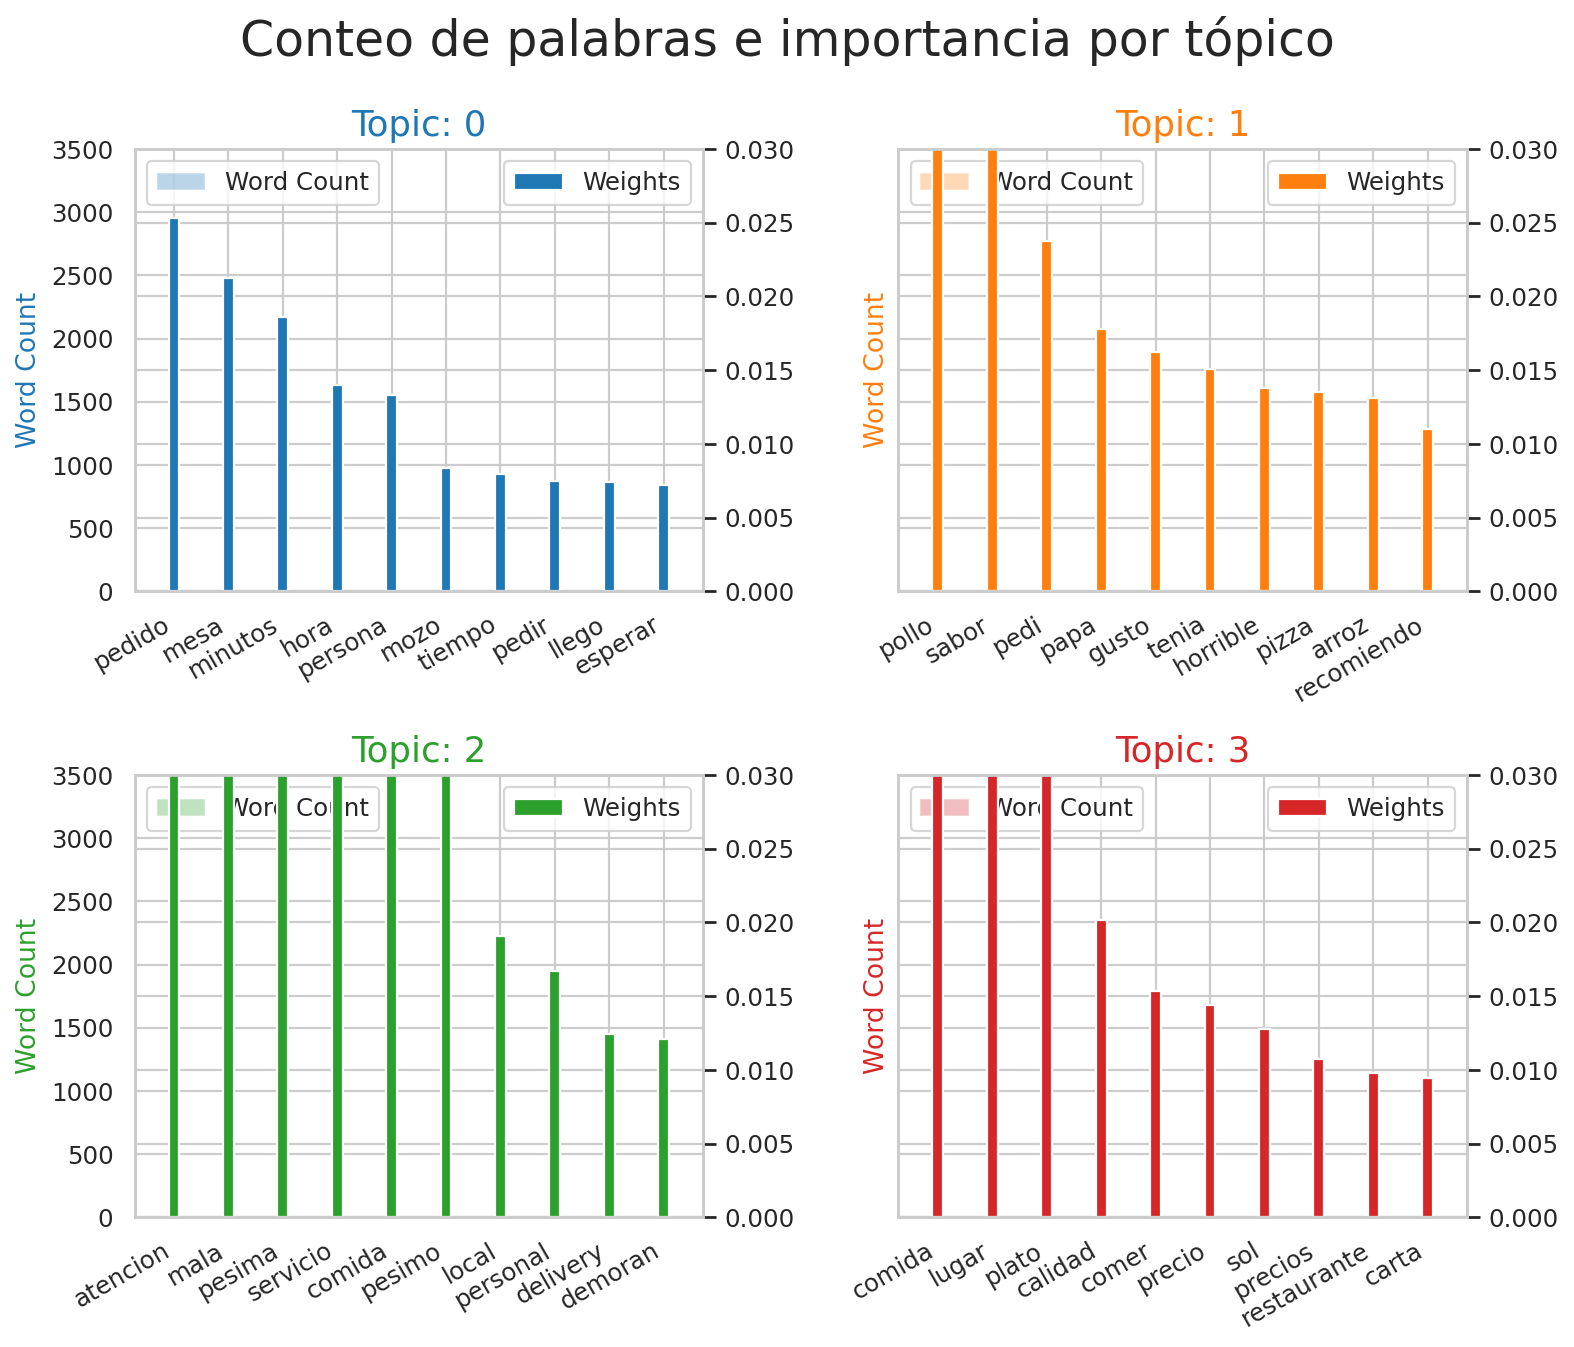

In [ ]:
from collections import Counter
import matplotlib.colors as mcolors

topics = optimal_model_mallet.show_topics(formatted=False)
data_flat = [w for w_list in df_reviews_negativos['review'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['palabra', 'topic_id', 'importancia', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='palabra', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='palabra', height="importancia", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'palabra'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Conteo de palabras e importancia por tópico', fontsize=22, y=1.05)    
plt.show()

## Graficando el modelo en 2 dimensiones

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Obtener los pesos de los tópicos
topic_weights = []
for i, row_list in enumerate(optimal_model_mallet[corpus]):
    topic_weights.append([w for i, w in row_list[0:]])

# Array con los pesos   
arr = pd.DataFrame(topic_weights).fillna(0).values

# Mantener lo puntos separados (opcional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Tópico dominante en cada documento
topic_num = np.argmax(arr, axis=1)

# tSNE Reducción de dimension
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Graficar los tópicos usando Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering de {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

In [ ]:
show(plot)

## Hallando los Tópicos más relevantes para cada Review y pesos

In [ ]:
# Obteniendo la distribución de tópicos por documento (review)
topic_dist = optimal_model_mallet[corpus]
df_topics = pd.DataFrame()
# Almacenamos distribuciones en una lista
dist = []
for t in topic_dist:
    dist.append(t)

rounded_dist = list(np.around(np.array(dist),3))

# añadimos la lista al dataframe
df_topics['Topic Distribution'] = pd.Series(rounded_dist)

In [ ]:
df_topics

,Topic Distribution
0,"[[0.0, 0.231], [1.0, 0.263], [2.0, 0.267], [3...."
1,"[[0.0, 0.473], [1.0, 0.122], [2.0, 0.138], [3...."
2,"[[0.0, 0.395], [1.0, 0.214], [2.0, 0.165], [3...."
3,"[[0.0, 0.21], [1.0, 0.298], [2.0, 0.19], [3.0,..."
4,"[[0.0, 0.204], [1.0, 0.266], [2.0, 0.233], [3...."
...,...
31996,"[[0.0, 0.24], [1.0, 0.24], [2.0, 0.279], [3.0,..."
31997,"[[0.0, 0.282], [1.0, 0.227], [2.0, 0.245], [3...."
31998,"[[0.0, 0.236], [1.0, 0.236], [2.0, 0.274], [3...."
31999,"[[0.0, 0.241], [1.0, 0.201], [2.0, 0.296], [3...."


In [ ]:
# dataset preview
df_rev_topics= pd.concat([df_reviews_negativos.reset_index(drop=True), df_topics.reset_index(drop=True)], axis=1,)

In [ ]:
df_rev_topics.head()

,id_review,review,title,score,likes,id_nick,service,date,platform,review_prep,review_final,review_final_token,Topic Distribution
0,R3005,Los acompañamientos muy malos. Los cortes de c...,Una mala experiencia,1.0,0,87carlosi,35956.0,1 years ago,tripadvisor,los acompañamientos muy malos los cortes de ca...,acompañamientos malos cortes carne vienen pone...,"[acompañamientos, malos, cortes, carne, vienen...","[[0.0, 0.231], [1.0, 0.263], [2.0, 0.267], [3...."
1,R3015,Trabajan dos versiones diferentes de la misma ...,Facturan de más sin avisar.,1.0,0,ervas10,35956.0,1 years ago,tripadvisor,trabajan dos versiones diferentes de la misma ...,trabajan versiones etiqueta cepa vino caso tra...,"[trabajan, versiones, etiqueta, cepa, vino, ca...","[[0.0, 0.473], [1.0, 0.122], [2.0, 0.138], [3...."
2,R3037,Llegue a este restaurante por recomendación de...,Un restaurante de Buda y despedida,1.0,0,osé M,35956.0,2 years ago,tripadvisor,llegue a este restaurante por recomendacion de...,llegue restaurante recomendacion youtuber loca...,"[llegue, restaurante, recomendacion, youtuber,...","[[0.0, 0.395], [1.0, 0.214], [2.0, 0.165], [3...."
3,R3058,Los 330 soles (US$100) peor invertidos. Fui co...,Malísimo !,1.0,0,abiioooo,35956.0,2 years ago,tripadvisor,los soles us$ peor invertidos fui con mi hija ...,soles us $ invertidos hija cabrera miraflores ...,"[sol, u, invertidos, hija, cabrera, miraflores...","[[0.0, 0.21], [1.0, 0.298], [2.0, 0.19], [3.0,..."
4,R3072,Acudimos en familia con ocasión de celebrar el...,Muy mala experiencia una decepción total,1.0,0,ongala,35956.0,3 years ago,tripadvisor,acudimos en familia con ocasion de celebrar el...,acudimos familia ocasion celebrar cumpleaños h...,"[acudimos, familia, ocasion, celebrar, cumplea...","[[0.0, 0.204], [1.0, 0.266], [2.0, 0.233], [3...."


In [ ]:
df_rev_topics.shape

(32001, 13)

## Obteniendo el tópico más relevante por review

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # dataframe vacio
    sent_topics_df = pd.DataFrame()

    # Obtener topico principal en cada review
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #Obtener el topico dominante, peso y Palabras clave por review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => topico dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model_mallet, corpus=corpus, texts=df_reviews_negativos['review'])

In [ ]:
df_topic_sents_keywords.Dominant_Topic.value_counts()

1.0    9834
2.0    9703
0.0    6597
3.0    5867
Name: Dominant_Topic, dtype: int64

In [ ]:
# Format0
df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,2.0,0.2668,"atencion, mala, pesima, servicio, comida, pesi..."
1,0.0,0.4731,"pedido, mesa, minutos, hora, persona, mozo, ti..."
2,0.0,0.3952,"pedido, mesa, minutos, hora, persona, mozo, ti..."
3,3.0,0.3025,"comida, lugar, plato, calidad, comer, precio, ..."
4,3.0,0.2964,"comida, lugar, plato, calidad, comer, precio, ..."


In [ ]:
df_rev_topics=  pd.concat([df_rev_topics.reset_index(drop=True), df_dominant_topic['Dominant_Topic']], axis=1,) 

In [ ]:
df_rev_topics.head()

,id_review,review,title,score,likes,id_nick,service,date,platform,review_prep,review_final,review_final_token,Topic Distribution,Dominant_Topic
0,R3005,Los acompañamientos muy malos. Los cortes de c...,Una mala experiencia,1.0,0,87carlosi,35956.0,1 years ago,tripadvisor,los acompañamientos muy malos los cortes de ca...,acompañamientos malos cortes carne vienen pone...,"[acompañamientos, malos, cortes, carne, vienen...","[[0.0, 0.231], [1.0, 0.263], [2.0, 0.267], [3....",2.0
1,R3015,Trabajan dos versiones diferentes de la misma ...,Facturan de más sin avisar.,1.0,0,ervas10,35956.0,1 years ago,tripadvisor,trabajan dos versiones diferentes de la misma ...,trabajan versiones etiqueta cepa vino caso tra...,"[trabajan, versiones, etiqueta, cepa, vino, ca...","[[0.0, 0.473], [1.0, 0.122], [2.0, 0.138], [3....",0.0
2,R3037,Llegue a este restaurante por recomendación de...,Un restaurante de Buda y despedida,1.0,0,osé M,35956.0,2 years ago,tripadvisor,llegue a este restaurante por recomendacion de...,llegue restaurante recomendacion youtuber loca...,"[llegue, restaurante, recomendacion, youtuber,...","[[0.0, 0.395], [1.0, 0.214], [2.0, 0.165], [3....",0.0
3,R3058,Los 330 soles (US$100) peor invertidos. Fui co...,Malísimo !,1.0,0,abiioooo,35956.0,2 years ago,tripadvisor,los soles us$ peor invertidos fui con mi hija ...,soles us $ invertidos hija cabrera miraflores ...,"[sol, u, invertidos, hija, cabrera, miraflores...","[[0.0, 0.21], [1.0, 0.298], [2.0, 0.19], [3.0,...",3.0
4,R3072,Acudimos en familia con ocasión de celebrar el...,Muy mala experiencia una decepción total,1.0,0,ongala,35956.0,3 years ago,tripadvisor,acudimos en familia con ocasion de celebrar el...,acudimos familia ocasion celebrar cumpleaños h...,"[acudimos, familia, ocasion, celebrar, cumplea...","[[0.0, 0.204], [1.0, 0.266], [2.0, 0.233], [3....",3.0


In [ ]:
#Canridad de reviews por topico
df_rev_topics.Dominant_Topic.value_counts()

## Asociando Tópicos para cada restaurante

In [ ]:
restaurants_df= restaurants_df[restaurants_df.district != ' ']
df_top_res = pd.merge(df_rev_topics,restaurants_df, left_on="service" , right_on="id")

In [ ]:
df_top_res= df_top_res.drop(['title','likes','id_nick','service','date','platform_x', 'platform_y','tag','x','y',
                                     'direction','min_price','max_price'], axis=1)

In [ ]:
df_top_res.to_csv('/content/drive/MyDrive/proyecto NLP/NLP/proyecto_v2/df_top_res.csv')

In [ ]:
df_top_res

,id_review,review,score,review_prep,review_final,review_final_token,Topic Distribution,Dominant_Topic,id,name,district,IDDIST,stars,n_reviews
0,R3005,Los acompañamientos muy malos. Los cortes de c...,1.0,los acompañamientos muy malos los cortes de ca...,acompañamientos malos cortes carne vienen pone...,"[acompañamientos, malos, cortes, carne, vienen...","[[0.0, 0.231], [1.0, 0.263], [2.0, 0.267], [3....",2.0,35956,La Cabrera Miraflores,BARRANCO,150104,40,665
1,R3015,Trabajan dos versiones diferentes de la misma ...,1.0,trabajan dos versiones diferentes de la misma ...,trabajan versiones etiqueta cepa vino caso tra...,"[trabajan, versiones, etiqueta, cepa, vino, ca...","[[0.0, 0.473], [1.0, 0.122], [2.0, 0.138], [3....",0.0,35956,La Cabrera Miraflores,BARRANCO,150104,40,665
2,R3037,Llegue a este restaurante por recomendación de...,1.0,llegue a este restaurante por recomendacion de...,llegue restaurante recomendacion youtuber loca...,"[llegue, restaurante, recomendacion, youtuber,...","[[0.0, 0.395], [1.0, 0.214], [2.0, 0.165], [3....",0.0,35956,La Cabrera Miraflores,BARRANCO,150104,40,665
3,R3058,Los 330 soles (US$100) peor invertidos. Fui co...,1.0,los soles us$ peor invertidos fui con mi hija ...,soles us $ invertidos hija cabrera miraflores ...,"[sol, u, invertidos, hija, cabrera, miraflores...","[[0.0, 0.21], [1.0, 0.298], [2.0, 0.19], [3.0,...",3.0,35956,La Cabrera Miraflores,BARRANCO,150104,40,665
4,R3072,Acudimos en familia con ocasión de celebrar el...,1.0,acudimos en familia con ocasion de celebrar el...,acudimos familia ocasion celebrar cumpleaños h...,"[acudimos, familia, ocasion, celebrar, cumplea...","[[0.0, 0.204], [1.0, 0.266], [2.0, 0.233], [3....",3.0,35956,La Cabrera Miraflores,BARRANCO,150104,40,665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29469,R1714603,Con la atención como siempre Lenta...,1.0,con la atencion como siempre lenta,atencion lenta,"[atencion, lenta]","[[0.0, 0.24], [1.0, 0.24], [2.0, 0.279], [3.0,...",2.0,71010,Hiper plazaVea Cortijo,BARRANCO,150104,42,6674
29470,R1714605,Falta se xortexia y ayuda con las personas may...,1.0,falta se xortexia y ayuda con las personas may...,falta xortexia ayuda personas mayores,"[falta, xortexia, ayuda, persona, mayores]","[[0.0, 0.282], [1.0, 0.227], [2.0, 0.245], [3....",0.0,71010,Hiper plazaVea Cortijo,BARRANCO,150104,42,6674
29471,R1714626,Bien surtida a diferencia de otros distritos.,1.0,bien surtida a diferencia de otros distritos,surtida diferencia distritos,"[surtida, diferencia, distritos]","[[0.0, 0.236], [1.0, 0.236], [2.0, 0.274], [3....",2.0,71010,Hiper plazaVea Cortijo,BARRANCO,150104,42,6674
29472,R1714686,Muuuuy malas me acaban de cobrar 35 soles por ...,1.0,muuuuy malas me acaban de cobrar soles por que...,muuuuy malas acaban cobrar soles cajera redond...,"[muuuuy, malas, acaban, cobrar, sol, cajera, r...","[[0.0, 0.241], [1.0, 0.201], [2.0, 0.296], [3....",2.0,71010,Hiper plazaVea Cortijo,BARRANCO,150104,42,6674


### Cantidad de reviews por restaurante

In [ ]:
df_res_conteo= df_top_res.name.value_counts().to_frame()
df_res_conteo

,name
KFC,919
Bembos,652
Norky's,562
McDonald's,480
Pizza Hut,476
...,...
Cervecería Barbarian,1
Curaka Bar,1
Chifa jou,1
La Barra Del Ceviche,1


### Conteo de cantidad de restaurantes para cada Tópico

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_conteo=df_top_res.groupby('Dominant_Topic')[['name']]. count()
df_conteo=df_conteo.reset_index()
df_conteo.columns = ['Dominant_Topic', 'Conteo']

In [ ]:
df_conteo

,Dominant_Topic,Conteo
0,0.0,6148
1,1.0,9060
2,2.0,8887
3,3.0,5379


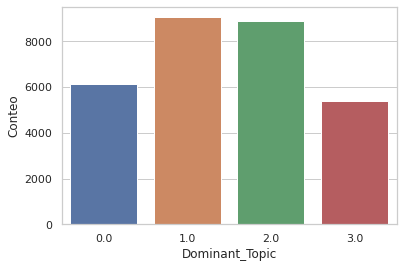

In [ ]:
sns.barplot(data=df_conteo, x="Dominant_Topic", y="Conteo")

### Tópicos principales para cada restaurante

In [ ]:
from scipy import stats

In [ ]:
df_res_prin_top= df_top_res.groupby(['name'])['Dominant_Topic'].agg(pd.Series.mode).to_frame()
df_res_prin_top

,Dominant_Topic
name,
""" MAMÁ ATTA """,0.0
"""Aquí me Quedo""",0.0
"""DATE UN GUSTO"" RESTAURANTE Y SANGUCHERIA",2.0
"""DON CARLITOS"" Pollos a la Brasa",1.0
"""Don Cevichero""","[0.0, 1.0]"
...,...
Ó-Mei,1.0
ámaZ Patio Panorama,3.0
ámaZ Restaurante,0.0


## Análisis de quejas para el restaurante: "Señor Limón"

In [ ]:
#import pandas as pd
#df_top_res=pd.read_csv('/content/drive/MyDrive/proyecto NLP/NLP/proyecto_v2/df_top_res.csv')

In [ ]:
df_srLimon= df_top_res.loc[df_top_res['name'] == 'Señor Limón']

In [ ]:
df_srLimon[['review','Dominant_Topic','district']].head()

,review,Dominant_Topic,district
917,Fui el día Domingo. El servicio fue muy lento ...,3.0,SAN MIGUEL
918,"Buena atención , pésima comida. Realmente una ...",3.0,SAN MIGUEL
14615,"Pésimo el servicio, la franquicia debería orde...",3.0,SAN ISIDRO
14616,El arroz con mariscos parecía una mazamorra si...,1.0,SAN ISIDRO
14617,Me decepcionó el camote del ceviche estaba muy...,1.0,SAN ISIDRO


### Motivo de quejas principal por sede:

In [ ]:
df_srLimon.groupby(['district'])['Dominant_Topic'].agg(pd.Series.mode)

district
LA MOLINA     1.0
SAN ISIDRO    3.0
SAN MIGUEL    3.0
Name: Dominant_Topic, dtype: float64

### Proporcion General de Tópicos para Señor Limón

In [ ]:
df_conteo2=df_srLimon.Dominant_Topic.value_counts().to_frame()
df_conteo2=df_conteo2.reset_index()
df_conteo2.columns = ['Dominant_Topic', 'Conteo']
df_conteo2

,Dominant_Topic,Conteo
0,3.0,35
1,1.0,25
2,2.0,18
3,0.0,13


In [ ]:
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
fig = px.pie(df_conteo2, values='Conteo', names='Dominant_Topic', title='Proporción de Tópicos de quejas a nivel General para Señor Limón ', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Proporcion por Sede

In [ ]:
df_conteo3=df_srLimon.groupby(['district', 'Dominant_Topic']).size()
df_conteo3=df_conteo3.reset_index()
df_conteo3.columns = ['distrito','Dominant_Topic', 'Conteo']
df_conteo3

,distrito,Dominant_Topic,Conteo
0,LA MOLINA,0.0,7
1,LA MOLINA,1.0,8
2,LA MOLINA,2.0,5
3,LA MOLINA,3.0,7
4,SAN ISIDRO,0.0,4
5,SAN ISIDRO,1.0,6
6,SAN ISIDRO,2.0,3
7,SAN ISIDRO,3.0,11
8,SAN MIGUEL,0.0,2
9,SAN MIGUEL,1.0,11


In [ ]:
from plotly.subplots import make_subplots

In [ ]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'} , {'type':'domain'}]])

fig.add_trace(go.Pie(labels=df_conteo3.Dominant_Topic, values=[7,8,5,7], name="Proporción de quejas Sede LA MOLINA"),
              1, 1)

fig.add_trace(go.Pie(labels=df_conteo3.Dominant_Topic, values=[4,6,3,11], name="Proporción de quejas Sede SAN ISIDRO"),
              1, 2)

fig.add_trace(go.Pie(labels=df_conteo3.Dominant_Topic, values=[2,11,10,17], name="Proporción de quejas Sede SAN MIGUEL"),
              1, 3)


fig.update_traces(hole=.4, hoverinfo="label+value+percent+name")

fig.update_layout(
    title_text="PROPORCIÓN DE TÓPICOS DE QUEJAS POR SEDE",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='LA MOLINA', x=0.10, y=0.5, font_size=20, showarrow=False),
                 dict(text='SAN ISIDRO', x=0.50, y=0.5, font_size=20, showarrow=False),
                 dict(text='SAN MIGUEL', x=0.90, y=0.5, font_size=20, showarrow=False)
                 ])

fig.show()

# ¡Gracias!